In [1]:
# Import necesary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-05-31 00:00:28.340726: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 00:00:28.340844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 00:00:28.494661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Define main directory 
data_dir = '/kaggle/input/flower/train-20240517T020347Z-001/train'

# Define the paths for the train, validation, and test sets
base_dir = '/kaggle/working'
train_dir = os.path.join(base_dir, 'train_split')
val_dir = os.path.join(base_dir, 'val_split')
test_dir = os.path.join(base_dir, 'test_split')

# Create directories 
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all flower types 
flower_types = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# Copy images to correct directory 
def copy_images(flower_type, images, dest_dir):
    dest_subdir = os.path.join(dest_dir, flower_type)
    if not os.path.exists(dest_subdir):  
        os.makedirs(dest_subdir, exist_ok=True)  # Create destination subdirectory if it doesn't exist
    for image in images:
        src_path = os.path.join(data_dir, flower_type, image)
        dest_path = os.path.join(dest_subdir, image)
        if os.path.isdir(dest_path):
            continue  # Skip if destination is a directory
        shutil.copy(src_path, dest_path)

# defining dataset split
train_split = 0.7
val_split = 0.15
test_split = 0.15

#iteratesthrough each flower copying images to correct directory
for flower_type in flower_types:
    images = os.listdir(os.path.join(data_dir, flower_type))
    train_images, test_images = train_test_split(images, test_size=(1 - train_split), random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=test_split/(val_split + test_split), random_state=42)
    
    copy_images(flower_type, train_images, train_dir)
    copy_images(flower_type, val_images, val_dir)
    copy_images(flower_type, test_images, test_dir)

print("Dataset split successfully into training, validation, and testing subsets.")


Dataset split successfully into training, validation, and testing subsets.


In [4]:
#defining batch and image size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 9542 files belonging to 14 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2048 files belonging to 14 classes.


In [7]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2052 files belonging to 14 classes.


Training phase

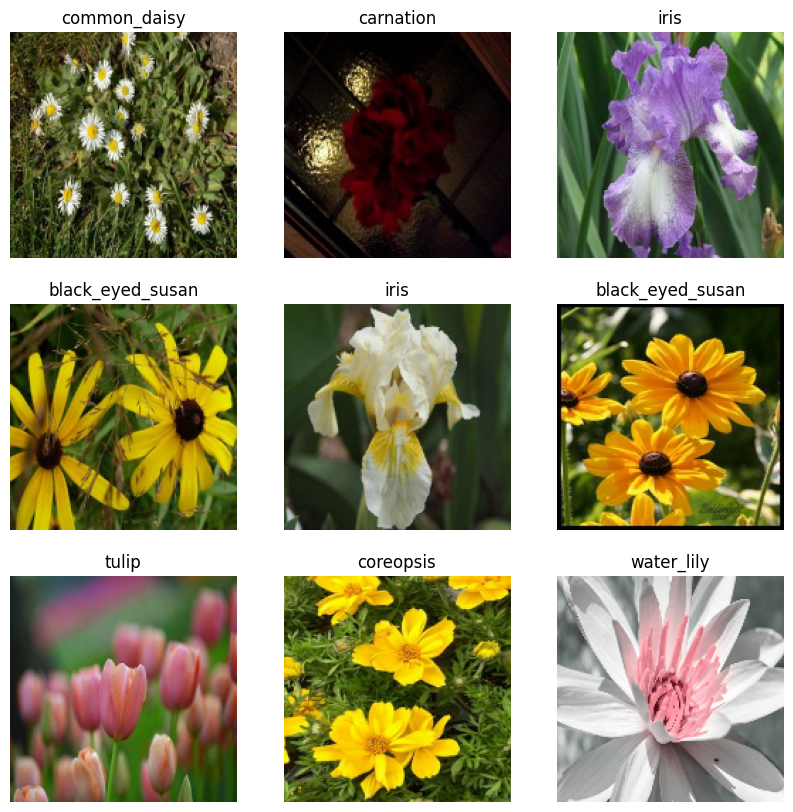

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 52
Number of test batches: 12


In [10]:
#prefetching data using autotune
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
#data augmentation to randomly flip and rotate images
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

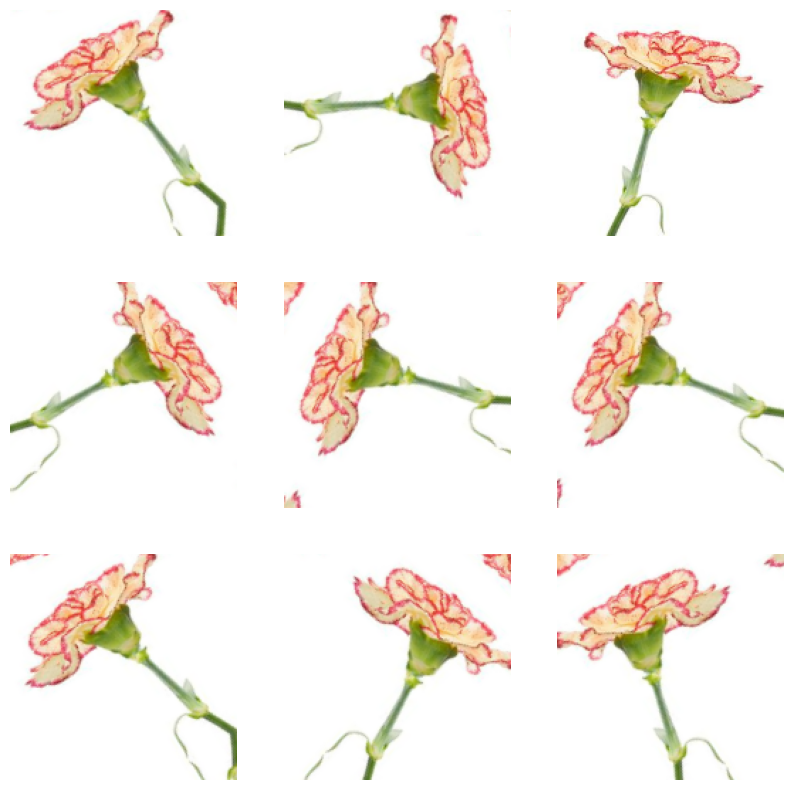

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Using pre-trained model MobileNet V2 as base model to increase accuracy
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(32, 5, 5, 1280)


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(14, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 14)


In [16]:
# creating final model implementing the data augmentation and preprocesing before base model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │        17,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,275,918 (8.68 MB)

 Trainable params: 17,934 (70.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# compiling model with accuracy metric
len(model.trainable_variables)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [18]:
#set epochs to 20 
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0743 - loss: 3.3565


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.36
initial accuracy: 0.08


In [20]:
#trainging model to determine accuracy on training and validation datasets
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.1811 - loss: 2.7427 - val_accuracy: 0.5847 - val_loss: 1.5240
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5658 - loss: 1.4222 - val_accuracy: 0.7326 - val_loss: 1.0142
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6998 - loss: 1.0150 - val_accuracy: 0.7891 - val_loss: 0.7990
Epoch 4/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7523 - loss: 0.8344 - val_accuracy: 0.8191 - val_loss: 0.6874
Epoch 5/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7813 - loss: 0.7236 - val_accuracy: 0.8329 - val_loss: 0.6076
Epoch 6/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8053 - loss: 0.6521 - val_accuracy: 0.8504 - val_loss: 0.5554
Epoch 7/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8152 - loss: 0.6004 - val_accuracy: 0.8552 - val_loss: 0.5282
Epoch 8/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8239 - loss: 0.5592 - 

In [21]:

#Training set Accuracy
train_loss, train_acc = model.evaluate(train_dataset)
print('Training accuracy:', train_acc)

299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8970 - loss: 0.3329
Training accuracy: 0.8986585736274719


In [22]:

#Validation set Accuracy
val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation accuracy:', val_acc)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8908 - loss: 0.3841
Validation accuracy: 0.8900240659713745


In [23]:
import keras


# Save the model weights
model.save('test_final_model.keras')

In [24]:

history.history

{'accuracy': [0.2943827211856842,
  0.6124502420425415,
  0.7167260646820068,
  0.7638859748840332,
  0.7889331579208374,
  0.8080067038536072,
  0.8186962604522705,
  0.8314818739891052,
  0.8350450396537781,
  0.8459442257881165,
  0.8511842489242554,
  0.8570530414581299,
  0.8601970076560974,
  0.8628170490264893,
  0.8717250227928162,
  0.8764410018920898,
  0.8756026029586792,
  0.8741353750228882,
  0.8758121728897095,
  0.8832529783248901],
 'loss': [2.2907848358154297,
  1.2953367233276367,
  0.9614543318748474,
  0.8080694675445557,
  0.7049190402030945,
  0.6419485211372375,
  0.5913888216018677,
  0.5443264245986938,
  0.5289450287818909,
  0.49866676330566406,
  0.4805701673030853,
  0.45288264751434326,
  0.447948157787323,
  0.4384719133377075,
  0.41786327958106995,
  0.40559127926826477,
  0.3971511721611023,
  0.39462244510650635,
  0.3908138871192932,
  0.37607818841934204],
 'val_accuracy': [0.5847355723381042,
  0.7325721383094788,
  0.7890625,
  0.8191105723381042

In [25]:


import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)

In [26]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 89.12259340286255 %


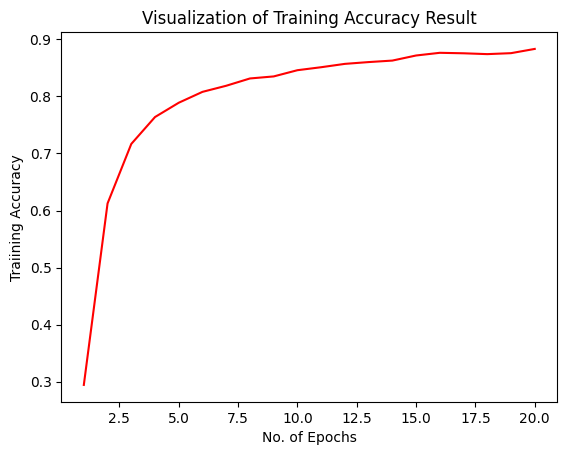

In [27]:

epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs,history.history['accuracy'],color='red')
plt.xlabel('No. of Epochs')
plt.ylabel('Traiining Accuracy')
plt.title('Visualization of Training Accuracy Result')
plt.show()

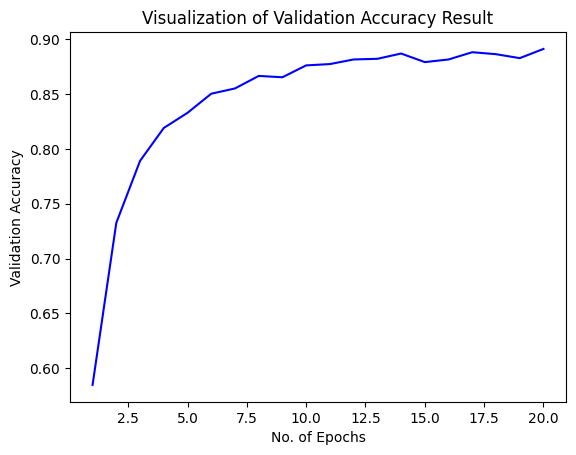

In [28]:

plt.plot(epochs,history.history['val_accuracy'],color='blue')
plt.xlabel('No. of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Visualization of Validation Accuracy Result')
plt.show()

In [29]:
test_loss,test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8904 - loss: 0.3609
Test accuracy: 0.8880208134651184


In [30]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [31]:
reconstructed_model = keras.models.load_model("/kaggle/working/test_final_model.keras")

In [32]:
reconstructed_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │        17,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,311,788 (8.82 MB)

 Trainable params: 17,934 (70.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 35,870 (140.12 KB)